<center><h1>Markov Chain Monte Carlo (Metropolis-Hastings) Parameter Estimation for Sky Temperature Model</h1></center>






<center><h3>By: Jorge Cárdenas</h3></center>

<center><h5>University of Antioquia, MSc in Physics</h5></center>


<center><img src="images/Edges_antenna.jpeg" width="400" height="200"></center>



In [1]:
from mc_sim.imports import *
import mc_sim.models as models
import mc_sim.MCMC as MCMC

import pylab as pl
%matplotlib inline


### ***1. Loading Data***
<a id='section1'></a>

<p style="font-family:verdana;color:#34495E;font-size:0.9em;">We have been provided with a dataframe, which has information about the behaviour of Sky signal temperature vs. the Frequency.</p>

<p style="font-family:verdana;color:#34495E;font-size:0.9em;">We are going to use that information as the source of truth for parameter estimation during the execution of the Markov-Chain Monte Carlo algorithm</p>



In [2]:
#Constants
sigma_parameter=0.024
column_names=['v','t_sky']
freq_central=75

#Parameters required for metropolis algorithm

num_walkers=5
num_samples=40000
burn_sample=500
test_to_run ="tests"#used to name saved data  
#np.random.seed(1)

#### ***1.1 Modules***
<a id='section1'></a>

<p style="font-family:verdana;color:#34495E;font-size:0.9em;">Two main modules have been developed.</p>

<p style="font-family:verdana;color:#34495E;font-size:0.9em;">
    <span style="color:red;" >Sky_model</span> , contains all methods required to calculate and set model parameters.</p>
<p style="font-family:verdana;color:#34495E;font-size:0.9em;">
    <span style="color:red;" >MCMC</span>, contains all methods for Monte Carlo Metropolis-hastings.</p>


In [3]:
sky_model=models.Sky_model()
parameters=sky_model.init_params()
Metropolis = MCMC.MCMC()

#### ***1.2 Model with experimetal data***
<a id='section1'></a>

<p style="font-family:verdana;color:#34495E;font-size:0.9em;">We have been given a dataset, carrying información Brightness Temperature. This information will become our value of truth we are going to compare againts during MCMC iterations</p>


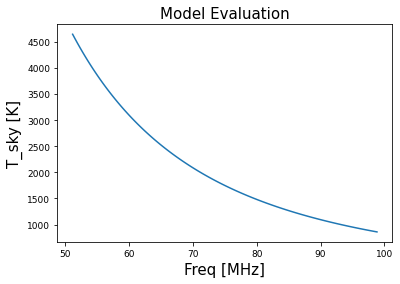

In [4]:

t_sky_data= sky_model.load_data()
palette = sns.color_palette("mako_r", 6)

fig = sns.lineplot(data=t_sky_data, x="Freq", y="t_sky",palette=palette)

fig.axes.set_title("Model Evaluation",fontsize=15)
fig.set_xlabel("Freq [MHz]",fontsize=15)
fig.set_ylabel("T_sky [K]",fontsize=15)
fig.tick_params(labelsize=9)



<a id='section2' ></a>
## ***2. Model***


<p style="font-family:verdana;color:#34495E;font-size:0.9em;">
The model for this projects, is intended to describe the behaviour of bright temperature of sky, accorging to,</p>



<img src="images/equation.png" width="500" height="200">

<p style="font-family:verdana;color:#34495E;font-size:0.9em;">
This model is derived from a model proposed by EDGES, where TBg represents cosmic background radiation, T21 is atmospheric absortion, and TFg is the first plane radiation. τion is the ionosphere opacity and Te is the electron temperature of the ionoshpere weighted by the opacity τ.</p>
<p style="font-family:verdana;color:#34495E;font-size:0.9em;">
That initial description is modified to get the model presented, which contains the following parameters.</p>

<table>
<thead>
<tr class="header">
<th style="text-align: left;width: 15%;">Param</th>
<th style="text-align: left;width: 15%;">Priori</th>
<th style="text-align: left;width: 15%;">Description</th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td style="text-align: left; width: 15%;"><span class="math inline">\(b_0\)</span></td>
<td style="text-align: left; width: 15%;"><span class="math inline">\(1700&lt;b_3&lt;1760\)</span></td>
<td style="text-align: left;width: 15%;">Temperatura en primer plano a una frecuencia <span class="math inline">\(\nu_c\)</span></td>
</tr>
<tr class="even">
<td style="text-align: left;width: 15%;"><span class="math inline">\(b_1\)</span></td>
<td style="text-align: left;width: 15%;"><span class="math inline">\(-0.1&lt;b_1&lt;-0.07\)</span></td>
<td style="text-align: left;width: 15%;">Corrección del indice espectral</td>
</tr>
<tr class="odd">
<td style="text-align: left;width: 15%;"><span class="math inline">\(b_2\)</span></td>
<td style="text-align: left;width: 15%;"><span class="math inline">\(-0.1&lt;b_2&lt;0.011\)</span></td>
<td style="text-align: left;width: 15%;">Constribución de orden superior</td>
</tr>
<tr class="even">
<td style="text-align: left;width: 15%;"><span class="math inline">\(b_3\equiv\tau_{0}\)</span></td>
<td style="text-align: left;width: 15%;"><span class="math inline">\(0.001&lt;b_3&lt;0.2\)</span></td>
<td style="text-align: left;width: 15%;">Opacidad de la ionósfera</td>
</tr>
<tr class="odd">
<td style="text-align: left;width: 15%;"><span class="math inline">\(T_e\)</span></td>
<td style="text-align: left;width: 15%;"><span class="math inline">\(200&lt;T_e&lt;2000\)</span></td>
<td style="text-align: left;width: 15%;">Temperatura de los electrones ponderada por la opacidad en la ionósfera.</td>
</tr>
</tbody>
</table>

____


<a id='section2' ></a>
#### ***2.1 Model Evaluation***


<p style="font-family:verdana;color:#34495E;font-size:0.9em;">
Here we evaluate the full model using some manualy introduced parameters to test the calculations are working properly.</p>

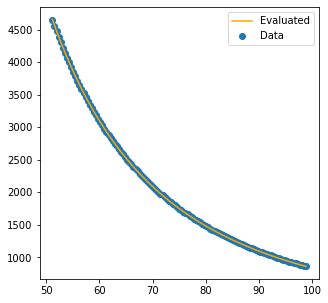

In [5]:

evaluated_model = sky_model.t_sky_model_full(parameters,t_sky_data.Freq,freq_central=freq_central)

"""Plot Evaluated Model"""
pl.rcParams['figure.figsize'] = (5.0, 5.0)
pl.plot(t_sky_data.Freq,evaluated_model, label="Evaluated",color='orange')
pl.scatter(t_sky_data.Freq,t_sky_data.t_sky, label="Data")
pl.legend()
pl.show()


## **3. Parameter estimation**



#### ***3.1 Metropolis-Hastings MCMC***

<p style="font-family:verdana;color:#34495E;font-size:0.9em;">In the next figure, you cand find the flor diagram for the most general algorithm applied in our case. At the heart of this process lies the acceptance algorithm which is using the fitness of every sample used during the iteratin process and compares to a uniform sample between 0 and 1, just like the theory requires for metropolis-hastings algorithm.</p>


<center><img src="images/flow.jpg" width="700" height="200"></center>


#### ***3.2 Fitness Evaluation***


<p style="font-family:verdana;color:#34495E;font-size:0.9em;">In mathematical notation, the correct likelihood function is:</p>

$$
    \ln\,p(y\,|\,x,\sigma,m,b,f) =
    -\frac{1}{2} \sum_n \left[
        \frac{(y_n-y_{sky})^2}{s_n^2}
        + \ln \left ( 2\pi\,s_n^2 \right )
    \right]
$$

<p style="font-family:verdana;color:#34495E;font-size:0.9em;">Where</p>


$$
    s_n^2 = \sigma_n^2+error \quad.
$$
<p style="font-family:verdana;color:#34495E;font-size:0.9em;">The added error, is taken from a gaussian distribution between 0 and 1, so we can have a sigma oscillating around 0.024</p>



In [6]:

#Select initial values for parameters

initial_point = Metropolis.gaussian_sample(parameters,1)

def model_evaluation(theta,v):
    return sky_model.EVAL_t_sky_model_full(theta,v,freq_central=75)
   

def evaluateLogLikelihood(theta,v,y,sigma):
    log_likelihood = 0
    yerr = 0.02 + 0.05 * np.random.uniform(0,1,1) #to consider an error in sigma calculation
    sn2 = yerr[0] ** 2
    #sn2=sigma**2  #this is used as the study case requires it this way
                    #Next step is to count sigma squared as a parameter to be tested as well

    evaluated_model = model_evaluation(theta,v)

    log_likelihood = ((-((1/(2*sn2))*sum(np.square(y-evaluated_model))) - (0.5*len(y)*np.log(2*np.pi*sn2))))

    return log_likelihood


#Running Metropolis algorithm
result,dataframe = Metropolis.MH(sky_model,
                                 parameters,
                                 t_sky_data,
                                 sigma_parameter,
                                 evaluateLogLikelihood,
                                 initial_point,
                                 num_walkers,
                                 num_samples,
                                 burn_sample)
#Markov Chain Thining
total_stack = Metropolis.thining(dataframe,num_samples )



100%|██████████| 200000/200000 [49:42<00:00, 67.07it/s]  


accepted53785.0


In [7]:
#total_stack= pd.read_csv(test_to_run+'/'+str("433609d5a3a8279f")+'.csv') 

total_stack = Metropolis.thining(dataframe,num_samples )
total_stack

,iteration,walker,accepted,likelihood,b0,b1,b2,b3,Te
26049,2501.0,0.0,1.0,-65567.088228,1753.651602,-0.074832,0.001155,0.004470,464.725255
15343,2502.0,0.0,0.0,-136824.277105,1753.651602,-0.074832,0.001155,0.004470,464.725255
6325,2503.0,0.0,0.0,-321317.406380,1753.651602,-0.074832,0.001155,0.004470,464.725255
29752,2504.0,0.0,1.0,-51125.013684,1753.813373,-0.074824,0.001010,0.004490,464.566162
27792,2505.0,0.0,0.0,-58499.126797,1753.813373,-0.074824,0.001010,0.004490,464.566162
...,...,...,...,...,...,...,...,...,...
149972,199994.0,4.0,0.0,-235163.112744,1741.487983,-0.050263,0.013562,-0.004343,726.699159
142499,199995.0,4.0,0.0,-394156.351162,1741.487983,-0.050263,0.013562,-0.004343,726.699159
137052,199996.0,4.0,0.0,-569393.179928,1741.487983,-0.050263,0.013562,-0.004343,726.699159
136248,199997.0,4.0,0.0,-605083.272484,1741.487983,-0.050263,0.013562,-0.004343,726.699159


##### ***3.1.1 Estimated values***


In [8]:
print(total_stack.describe().loc[['mean']])
estimator=np.median(total_stack,axis=0)
print(estimator)

          iteration  walker  accepted    likelihood           b0        b1  \
mean  100983.348527     2.0  0.290333 -7.521216e+06  1754.176049 -0.065401   

            b2        b3          Te  
mean  0.002941  0.003678  611.136095  
[ 9.75005000e+04  2.00000000e+00  0.00000000e+00 -4.84494677e+05
  1.75442549e+03 -6.46195650e-02  4.80854298e-04  3.80800886e-03
  6.30524804e+02]


#### ***3.3 Saving Results***

<p style="font-family:verdana;color:#34495E;font-size:0.9em;">Here we save data from MCMC. There is a csv file with the whole information from every iteration.</p>
<p style="font-family:verdana;color:#34495E;font-size:0.9em;">You can see your results in the folder named by the <span style="font-weight:bold">test_to_run</span> variable</p>

<Figure size 360x360 with 0 Axes>

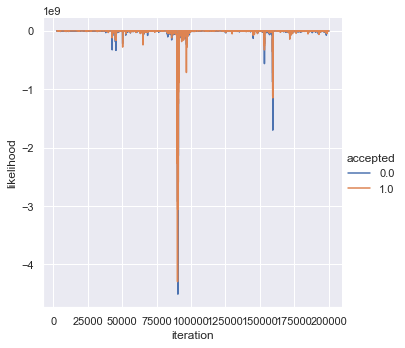

In [9]:
if not os.path.exists(test_to_run):
    os.makedirs(test_to_run)

sec = secrets.token_hex(nbytes=8)
sns.set_theme()
plt.figure();

plot = sns.relplot(
    data=total_stack[["iteration","likelihood","walker","accepted"]],kind="line",
    x="iteration", y="likelihood",
    hue="accepted",facet_kws=dict(sharex=False),
)

"""Saving Results"""
plot.figure.savefig(test_to_run+"/"+str(sec)+"_dash.png") 
total_stack.to_csv(test_to_run+"/"+str(sec)+'.csv', index=False)


## **4. Results**



<p style="font-family:verdana;color:#34495E;font-size:0.9em;">Next step is to load data in order to analyze what we obtained from MCMC.</p>

<p style="font-family:verdana;color:#34495E;font-size:0.9em;">The Chain,the one containing the distirbution information after M-H algorithm, needs to be cleaned.</p>
<p style="font-family:verdana;color:#34495E;font-size:0.9em;"><li>There is a need to drop the earliest part of the sampling process, because is the one far from convergence.</li>
<li>Thining of the chain, is the second process, and that is selecting just a part of the sampled data</li></p>


In [10]:
total_stack= pd.read_csv(test_to_run+'/'+str(sec)+'.csv') 


#### ***4.1 Distribution***

<p style="font-family:verdana;color:#34495E;font-size:0.9em;">Next, you can find the plots to show how the Markov Chain is presenting a distribution for every parameter. Also, there can be seen the correlation between every parameter.</p>


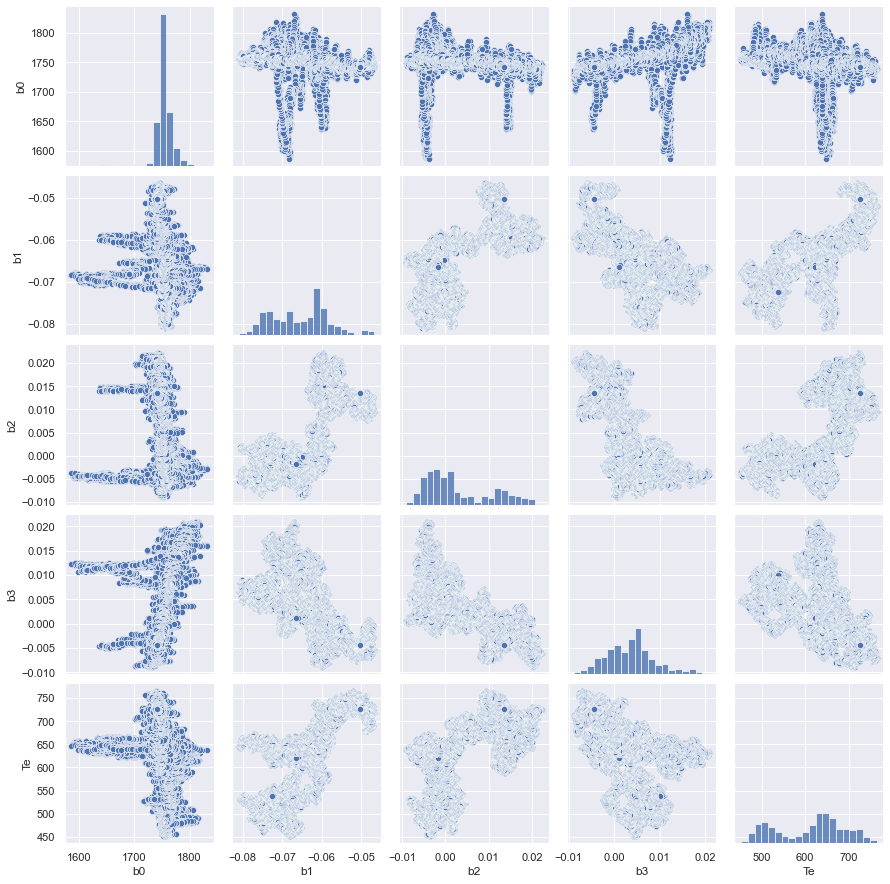

In [19]:

total_stack = total_stack[['b0',"b1","b2","b3","Te"]]

fig= sns.pairplot(total_stack, kind="scatter",diag_kws = {'alpha':0.8, 'bins':20})
fig.savefig(test_to_run+'/pair_plot_Test9.png')

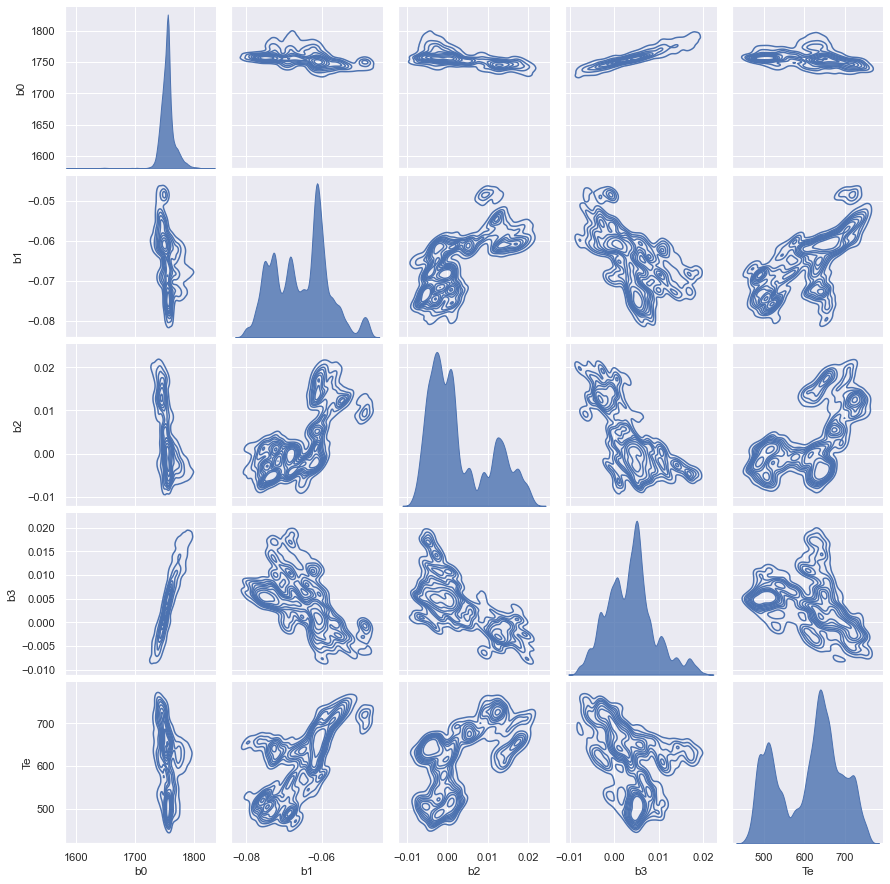

In [20]:

total_stack = total_stack[['b0',"b1","b2","b3","Te"]]

fig= sns.pairplot(total_stack, kind="kde",diag_kws = {'alpha':0.8})
fig.savefig(test_to_run+'/pair_plot_KDE_Test9.png')


#### ***4.1 Parameters***

<p style="font-family:verdana;color:#34495E;font-size:0.9em;">Finally, We can show every parameter individually. There is a clear distribution and mean values for every one of them.</p>

<p style="font-family:verdana;color:#34495E;font-size:0.9em;">As for the  <span style="color:red;" >b0</span>  parameter, we find there is always a peak around 1750-1750 </p>

<p style="font-family:verdana;color:#34495E;font-size:0.9em;">The other parameter of big interest is  <span style="color:red;" >Te</span> . Though the effect of Te on the whole function, is precisely what we are looking for: account for the slightest contribution to sky brightness, so we can be more sure about the disturbances of inosphere on signals. </p>


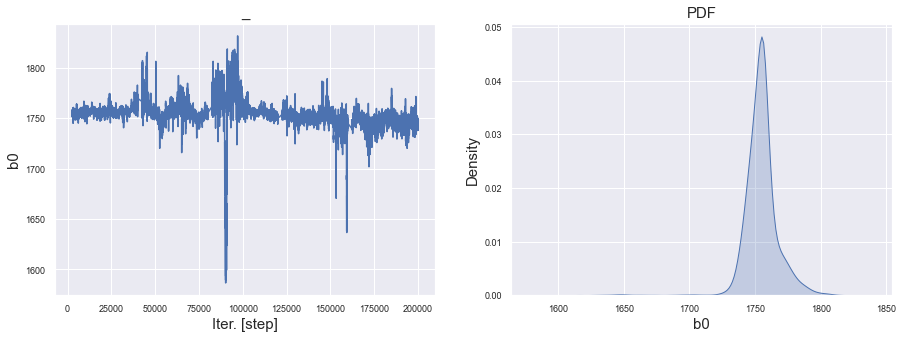

In [21]:
total_stack= pd.read_csv(test_to_run+'/'+str(sec)+'.csv') 

fig, ax =plt.subplots(1,2)
fig.set_size_inches(15, 5)


#plt.figure(figsize=(5,5))
data = sns.kdeplot(total_stack.b0,shade=True,bw_method=0.2)
iterations = sns.lineplot(data=total_stack[["b0","iteration"]], x="iteration",y="b0",sort=False,ax=ax[0])

iterations.axes.set_title("_",fontsize=15)
iterations.set_xlabel("Iter. [step]",fontsize=15)
iterations.set_ylabel("b0",fontsize=15)
iterations.tick_params(labelsize=9)

data.axes.set_title("PDF",fontsize=15)
data.set_xlabel("b0",fontsize=15)
data.set_ylabel("Density",fontsize=15)
data.tick_params(labelsize=9)

plt.show()

fig.savefig(test_to_run+'/distb0.png')

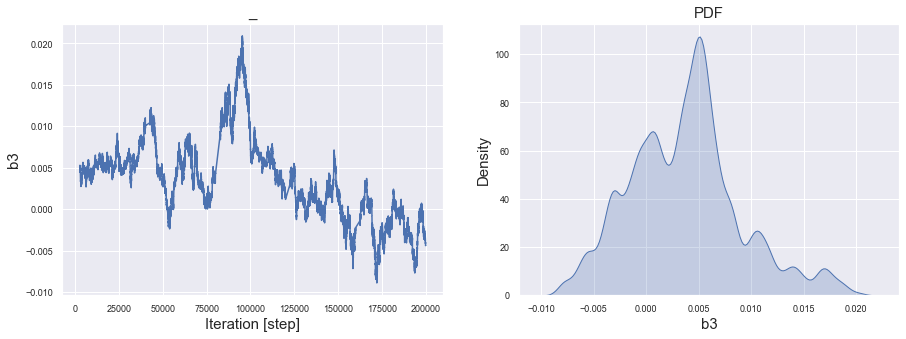

In [22]:
fig, ax =plt.subplots(1,2)
fig.set_size_inches(15, 5)


#plt.figure(figsize=(5,5))
data = sns.kdeplot(total_stack.b3,shade=True,bw_method=0.1)
iterations = sns.lineplot(data=total_stack[["b3","iteration"]], x="iteration",y="b3",sort=False,ax=ax[0])

iterations.axes.set_title("_",fontsize=15)
iterations.set_xlabel("Iteration [step]",fontsize=15)
iterations.set_ylabel("b3",fontsize=15)
iterations.tick_params(labelsize=9)

data.axes.set_title("PDF",fontsize=15)
data.set_xlabel("b3",fontsize=15)
data.set_ylabel("Density",fontsize=15)
data.tick_params(labelsize=9)

plt.show()
fig.savefig(test_to_run+'/distb3.png')

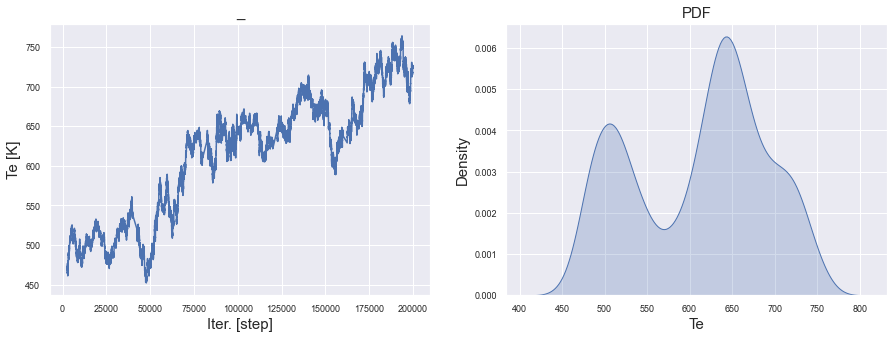

In [23]:

fig, ax =plt.subplots(1,2)
fig.set_size_inches(15, 5)


#plt.figure(figsize=(5,5))
data = sns.kdeplot(total_stack.Te,shade=True,bw_method=0.2)
iterations = sns.lineplot(data=total_stack[["Te","iteration"]], x="iteration",y="Te",sort=False,ax=ax[0])

iterations.axes.set_title("_",fontsize=15)
iterations.set_xlabel("Iter. [step]",fontsize=15)
iterations.set_ylabel("Te [K]",fontsize=15)
iterations.tick_params(labelsize=9)

data.axes.set_title("PDF",fontsize=15)
data.set_xlabel("Te",fontsize=15)
data.set_ylabel("Density",fontsize=15)
data.tick_params(labelsize=9)

plt.show()
fig.savefig(test_to_run+'/Te.png')

#### ***4.2 Testing the parameters***

<p style="font-family:verdana;color:#34495E;font-size:0.9em;">Our final step is to test the parameters, using them to calculate the model in the given range of frequencies we are working on. </p>

<p style="font-family:verdana;color:#34495E;font-size:0.9em;">As you can see, there is an important fit between the simulated results from the parameters we have found and the curve given at the beginning. </p>

In [24]:
theta_test = total_stack.describe().loc[['mean']]
theta_test

,iteration,walker,accepted,likelihood,b0,b1,b2,b3,Te
mean,100983.348527,2.0,0.290333,-7.521216e+06,1754.176049,-0.065401,0.002941,0.003678,611.136095


Theta from Sample =[1754.1760485058003, -0.0654009992267079, 0.002940675861763864, 0.0036778734181637756, 611.1360950562854]


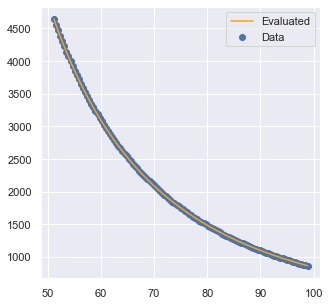

In [25]:

theta_test=[theta_test["b0"]["mean"],theta_test["b1"]["mean"],theta_test["b2"]["mean"], theta_test["b3"]["mean"],theta_test["Te"]["mean"]]

evaluate_model_theta = sky_model.EVAL_t_sky_model_full(theta_test,
                                                        t_sky_data.Freq,
                                                        freq_central=freq_central)

"""Plot Evaluated Model"""
print("Theta from Sample =" + str(theta_test))

pl.rcParams['figure.figsize'] = (5.0, 5.0)
pl.plot(t_sky_data.Freq,evaluate_model_theta, label="Evaluated",color='orange')
pl.scatter(t_sky_data.Freq,t_sky_data.t_sky, label="Data")
pl.legend()
pl.show()

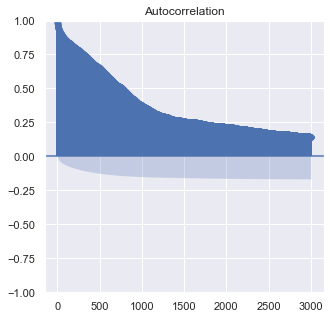

In [26]:

from matplotlib import pyplot
fig= plot_acf(total_stack.b0,lags=3000)
pyplot.show()
fig.savefig(test_to_run+'/autocorrelation.png')

# **References**

[1] Bowman, J. D., Rogers, A. E. E., Monsalve, R. A., Mozdzen, T. J., & Mahesh, N. (2018). figure1_plotdata.csv

[2] Hills, R., Kulkarni, G., Meerburg, P. D., & Puchwein, E. (2018). Concerns about modelling of the EDGES data. Nature, 564(7736), E32–E34. https://doi.org/10.1038/s41586-018-0796-5

[3] Bowman, J. D., Rogers, A. E. E., Monsalve, R. A., Mozdzen, T. J., & Mahesh, N. (2018). An absorption profile centred at 78 megahertz in the sky-averaged spectrum. Nature, 555(7694), 67–70. https://doi.org/10.1038/nature25792

[4] Cowan, G. (1998). Statistical Data Analysis (1st ed.). Oxford University Press.

[5] Thomas, C. D. (2018). Concerns about modelling of the EDGES data. Nature, 1–2. https://doi.org/https://doi.org/10.1038/s41586-018-0796-5